# MOVIE RECOMMENDER

## Business Understanding

Users often struggle to choose what to watch. Personalized movie recommendations can help cut through the noise, offering tailored suggestions that enhance user satisfaction, boost engagement, and encourage longterm use. This project aims to build a recommendation system to simulate how such platforms deliver personalized experiences.

## Data Preparation

In [55]:
# Installing necessary libraries
!pip install numpy==1.23.5
!pip install scikit-surprise
!pip install wordcloud

In [56]:
# Loading the relevant libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD
from sklearn.metrics.pairwise import cosine_similarity



#NLP Libraries
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#Wordcloud to visualize most frequent terms in the tags
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
# Loading the data
# Load specific CSV files inside the folder
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')
tags = pd.read_csv('/content/tags.csv')
links = pd.read_csv('/content/links.csv')

### Data Understanding

In [58]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [59]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [60]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [61]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [62]:
movies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [63]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [64]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [65]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


### Data Cleaning

Checking for missing values

In [66]:
movies.isnull().sum()

,0
movieId,0
title,0
genres,0


In [67]:

ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


In [68]:

tags.isnull().sum()

,0
userId,0
movieId,0
tag,0
timestamp,0


In [69]:

links.isnull().sum()

,0
movieId,0
imdbId,0
tmdbId,8


In [70]:
#Dropping the missing values.

links.dropna(subset=['tmdbId'], inplace=True)

links.isnull().sum()

,0
movieId,0
imdbId,0
tmdbId,0


## Data Preprocessing

In [71]:
#Converting the timestamp column into datetime format

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [72]:
#Converting the timestamp column into datetime format

tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,2015-10-24 19:29:54
1,2,60756,Highly quotable,2015-10-24 19:29:56
2,2,60756,will ferrell,2015-10-24 19:29:52
3,2,89774,Boxing story,2015-10-24 19:33:27
4,2,89774,MMA,2015-10-24 19:33:20


In [73]:
#Extract the year from the title column

movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = movies['year'].fillna(0).astype(int)

In [74]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
 3   year     9742 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 304.6+ KB


In [75]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [76]:
# Merge ratings and movies

df = pd.merge(ratings, movies, on='movieId')

df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,1995
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,1995
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995


In [77]:
# Splitting genres

df['genre_list'] = df['genres'].apply(lambda x: x.split('|'))

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_)
df = pd.concat([df, genre_encoded], axis=1)

Merged ratings and movies because we will need genres, titles, and ratings together to do feature engineering and modeling.

Extracted Year from the title of the movie because older movies might be rated differently. Movie age is useful for modeling.

Converted the timestamp column into date time format to make more sense for this analysis.

Splitted genres because we need to turn genres into numbers(binary columns) to use them in machine learning

### EDA

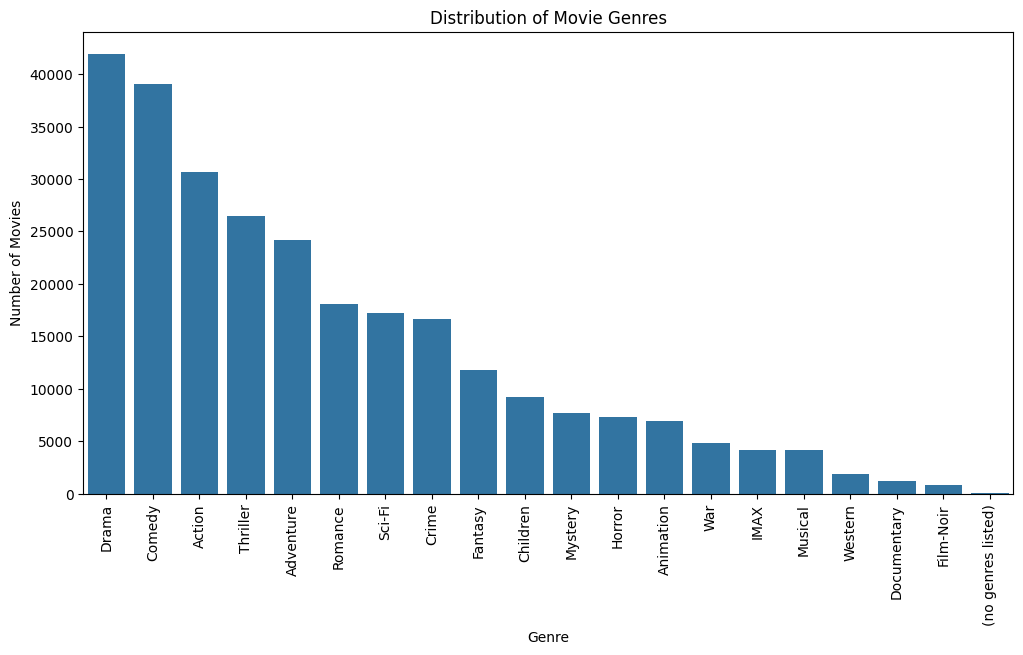

Most Common Genres:
genres
Drama        41928
Comedy       39053
Action       30635
Thriller     26452
Adventure    24161
Romance      18124
Sci-Fi       17243
Crime        16681
Fantasy      11834
Children      9208
Name: count, dtype: int64


In [78]:
# Analyze Top genre distribution

genre_counts = df['genres'].str.split('|').explode().value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=90)
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.show()

print("Most Common Genres:")
print(genre_counts.head(10))

Text(0.5, 1.0, 'Ratings per Movie')

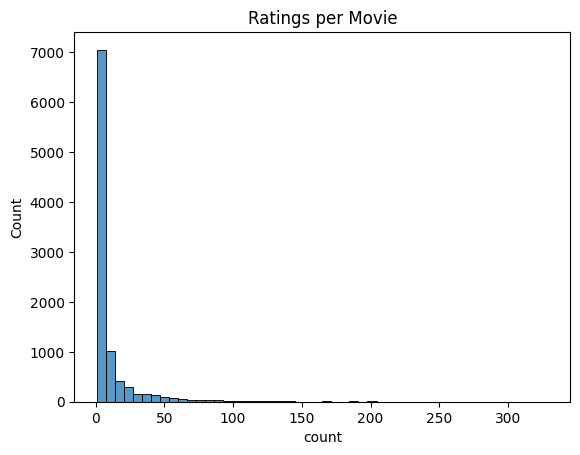

In [79]:
# Movie popularity

movie_popularity = df['movieId'].value_counts()
sns.histplot(movie_popularity, bins=50, kde=False)
plt.title('Ratings per Movie')

In [80]:
# Number of Unique Users and Movies

print("Number of unique users:", df['userId'].nunique())
print("Number of unique movies:", df['movieId'].nunique())


Number of unique users: 610
Number of unique movies: 9724


In [81]:
# Ratings Distribution

print("Rating distribution:")
df['rating'].value_counts().sort_index()

Rating distribution:


,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


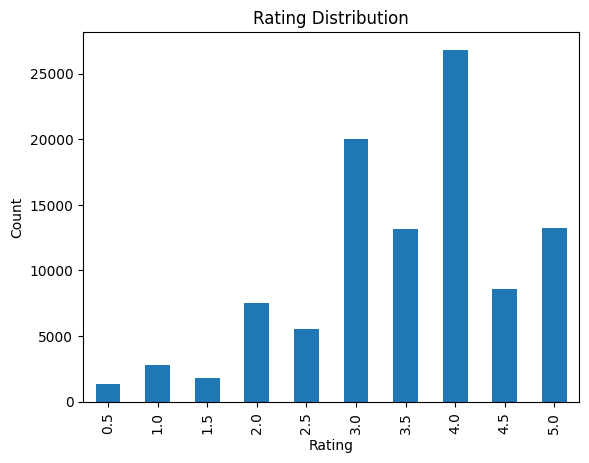

In [82]:
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [83]:
# Ratings per user
ratings_per_user = df.groupby('userId')['rating'].count()
print("Average ratings per user:", ratings_per_user.mean())

# Ratings per movie
ratings_per_movie = df.groupby('movieId')['rating'].count()
print("Average ratings per movie:", ratings_per_movie.mean())

Average ratings per user: 165.30491803278687
Average ratings per movie: 10.369806663924312


In [84]:
print("Top users by number of ratings:")
print(ratings_per_user.sort_values(ascending=False).head())

print("Top movies by number of ratings:")
top_movies = ratings_per_movie.sort_values(ascending=False).head()
print(top_movies)


Top users by number of ratings:
userId
414    2698
599    2478
474    2108
448    1864
274    1346
Name: rating, dtype: int64
Top movies by number of ratings:
movieId
356     329
318     317
296     307
593     279
2571    278
Name: rating, dtype: int64


In [85]:
most_rated = movies.groupby('title').size().sort_values(ascending=False).head(10)
print(most_rated)

title
Confessions of a Dangerous Mind (2002)         2
Emma (1996)                                    2
Eros (2004)                                    2
War of the Worlds (2005)                       2
Saturn 3 (1980)                                2
Partisan (2015)                                1
Parenthood (1989)                              1
Paris Is Burning (1990)                        1
Paris, I Love You (Paris, je t'aime) (2006)    1
Paris, Texas (1984)                            1
dtype: int64


### Feature Engineering

One Hot-Encode Genres

In [86]:
# Splitting genres

df['genre_list'] = df['genres'].apply(lambda x: x.split('|'))

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_)
df = pd.concat([df, genre_encoded], axis=1)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 48 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   userId              100836 non-null  int64         
 1   movieId             100836 non-null  int64         
 2   rating              100836 non-null  float64       
 3   timestamp           100836 non-null  datetime64[ns]
 4   title               100836 non-null  object        
 5   genres              100836 non-null  object        
 6   year                100836 non-null  int64         
 7   genre_list          100836 non-null  object        
 8   (no genres listed)  100836 non-null  int64         
 9   Action              100836 non-null  int64         
 10  Adventure           100836 non-null  int64         
 11  Animation           100836 non-null  int64         
 12  Children            100836 non-null  int64         
 13  Comedy              100836 no

In [88]:
df.head()

,userId,movieId,rating,timestamp,title,genres,year,genre_list,(no genres listed),Action,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,1995,"[Comedy, Romance]",0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,1995,"[Action, Crime, Thriller]",0,1,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995,"[Mystery, Thriller]",0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995,"[Crime, Mystery, Thriller]",0,0,...,0,0,0,0,1,0,0,1,0,0


In [89]:
df.drop(columns=['(no genres listed)'], inplace = True)

In [90]:
df.drop(columns=['genre_list'], inplace=True)


In [91]:
#  Filter Rarely Rated Movies / Users (Cold Start Filtering)
# For modeling, remove users/movies with too few ratings

def filter_rare_interactions(df, user_threshold, movie_threshold):
    """
    Filters out users and movies with a low number of interactions.

    Args:
        df: DataFrame containing user-movie interactions.
        user_threshold: Minimum number of movies rated by a user.
        movie_threshold: Minimum number of ratings for a movie.

    Returns:
        Filtered DataFrame.
    """

    # Count user and movie interactions
    user_counts = df['userId'].value_counts()
    movie_counts = df['movieId'].value_counts()

    # Identify users and movies to keep
    active_users = user_counts[user_counts >= user_threshold].index
    popular_movies = movie_counts[movie_counts >= movie_threshold].index

    # Filter the DataFrame
    filtered_df = df[
        (df['userId'].isin(active_users)) & (df['movieId'].isin(popular_movies))
    ]

    return filtered_df


user_threshold = 5
movie_threshold = 5
filtered_ratings = filter_rare_interactions(ratings, user_threshold, movie_threshold)

print(f"Original DataFrame shape: {ratings.shape}")
print(f"Filtered DataFrame shape: {filtered_ratings.shape}")

Original DataFrame shape: (100836, 4)
Filtered DataFrame shape: (90274, 4)


Merging Ratings with Movie Info
to help associate each rating with a movie title and genre.

In [92]:
df_ratings_movies = pd.merge(ratings, movies, on='movieId', how='left')
print(df_ratings_movies.head())

   userId  movieId  rating           timestamp                        title  \
0       1        1     4.0 2000-07-30 18:45:03             Toy Story (1995)   
1       1        3     4.0 2000-07-30 18:20:47      Grumpier Old Men (1995)   
2       1        6     4.0 2000-07-30 18:37:04                  Heat (1995)   
3       1       47     5.0 2000-07-30 19:03:35  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0 2000-07-30 18:48:51   Usual Suspects, The (1995)   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1                               Comedy|Romance  1995  
2                        Action|Crime|Thriller  1995  
3                             Mystery|Thriller  1995  
4                       Crime|Mystery|Thriller  1995  


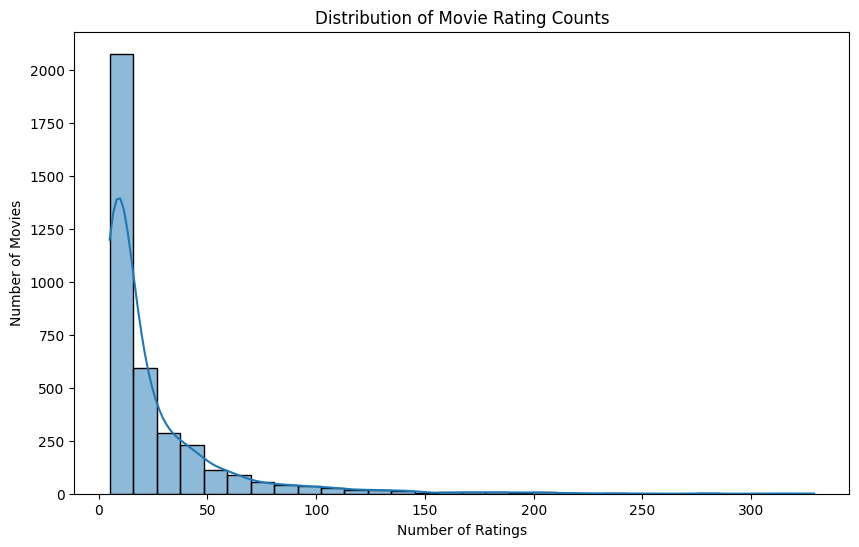

In [93]:
# Calculate movie popularity
movie_popularity = filtered_ratings.groupby('movieId')['userId'].count().reset_index()
movie_popularity.columns = ['movieId', 'rating_count']

# Define popularity thresholds (adjust as needed)
popularity_threshold = movie_popularity['rating_count'].median()
movie_popularity['popularity_level'] = movie_popularity['rating_count'].apply(
    lambda x: 'Popular' if x >= popularity_threshold else 'Obscure'
)

# Merge popularity information with movie details
movie_popularity = pd.merge(movie_popularity, movies[['movieId', 'title']], on='movieId', how='left')


# Visualization: Movie Popularity Distribution
plt.figure(figsize=(10, 6))
sns.histplot(movie_popularity['rating_count'], bins=30, kde=True)
plt.title('Distribution of Movie Rating Counts')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

#Further analysis and visualization
popular_movies = movie_popularity[movie_popularity['popularity_level'] == 'Popular']
obscure_movies = movie_popularity[movie_popularity['popularity_level'] == 'Obscure']

Create the user-item matrix to represents user preferences explicitly.

In [94]:
# Create the user-movie rating matrix
ratings_matrix = filtered_ratings.pivot_table(index='userId', columns='movieId', values='rating')

# Fill missing values with 0 (indicating no rating)
ratings_matrix = ratings_matrix.fillna(0)

print(ratings_matrix.head())

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  176371  177593  177765  179401  179819  180031  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0

Looking at how engaged users are

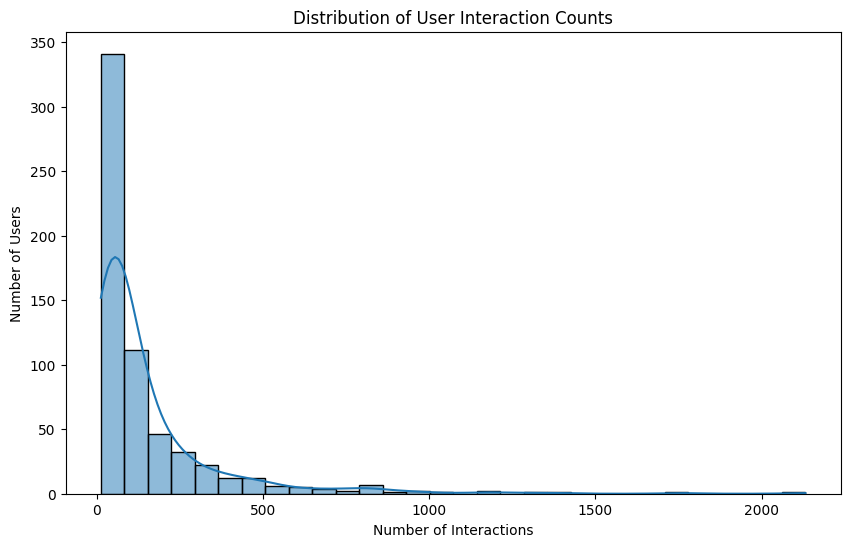

In [95]:
# Calculate user engagement metrics
user_engagement = filtered_ratings.groupby('userId')['movieId'].count().reset_index()
user_engagement.columns = ['userId', 'interaction_count']

# Define engagement categories
engagement_threshold = user_engagement['interaction_count'].median()
user_engagement['engagement_level'] = user_engagement['interaction_count'].apply(lambda x: 'Frequent' if x >= engagement_threshold else 'Occasional')

# Visualization: Distribution of Interaction counts
plt.figure(figsize=(10, 6))
sns.histplot(user_engagement['interaction_count'], bins=30, kde=True)
plt.title('Distribution of User Interaction Counts')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.show()


Identifying popular vs obscure movies so as to help with understanding cold-start issues

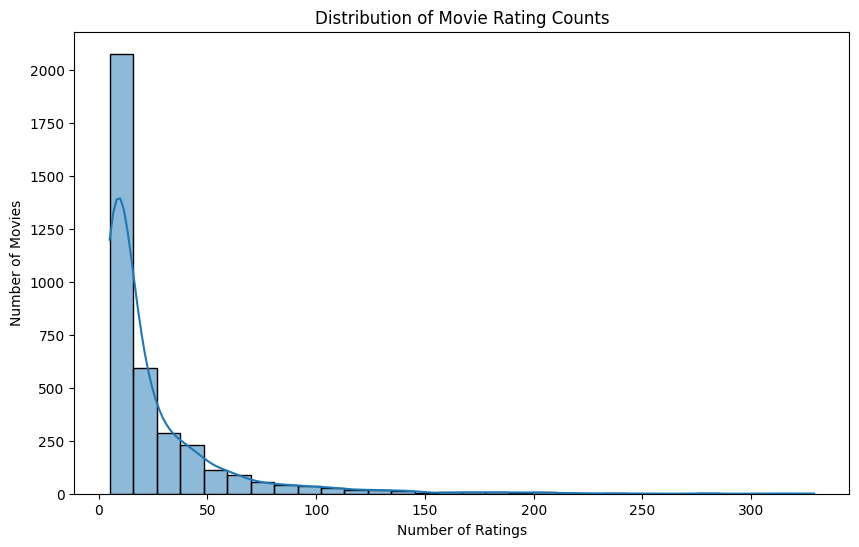


Popular Movies (Examples):
   movieId  rating_count popularity_level                               title
0        1           215          Popular                    Toy Story (1995)
1        2           110          Popular                      Jumanji (1995)
2        3            52          Popular             Grumpier Old Men (1995)
4        5            49          Popular  Father of the Bride Part II (1995)
5        6           102          Popular                         Heat (1995)

Obscure Movies (Examples):
    movieId  rating_count popularity_level                     title
3         4             7          Obscure  Waiting to Exhale (1995)
7         8             8          Obscure       Tom and Huck (1995)
12       13             8          Obscure              Balto (1995)
26       27             9          Obscure       Now and Then (1995)
27       28            11          Obscure         Persuasion (1995)


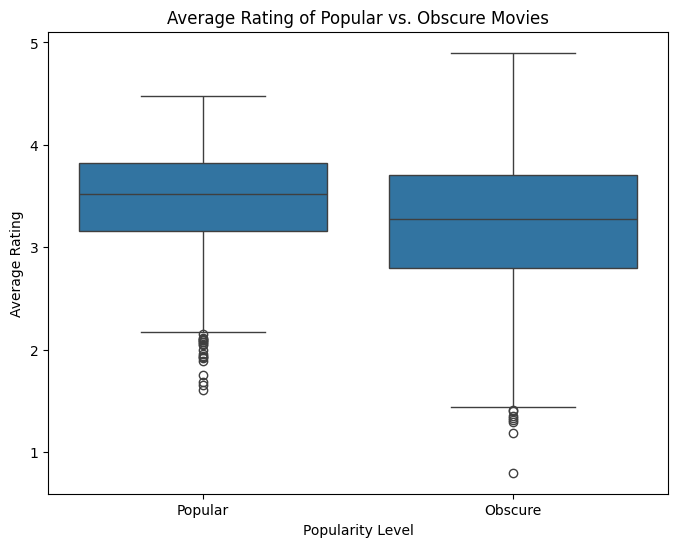

In [96]:
# Calculate movie popularity
movie_popularity = filtered_ratings.groupby('movieId')['userId'].count().reset_index()
movie_popularity.columns = ['movieId', 'rating_count']

# Define popularity thresholds (adjust as needed)
popularity_threshold = movie_popularity['rating_count'].median()
movie_popularity['popularity_level'] = movie_popularity['rating_count'].apply(
    lambda x: 'Popular' if x >= popularity_threshold else 'Obscure'
)

# Merge popularity information with movie details
movie_popularity = pd.merge(movie_popularity, movies[['movieId', 'title']], on='movieId', how='left')


# Visualization: Movie Popularity Distribution
plt.figure(figsize=(10, 6))
sns.histplot(movie_popularity['rating_count'], bins=30, kde=True)
plt.title('Distribution of Movie Rating Counts')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

#Further analysis and visualization
popular_movies = movie_popularity[movie_popularity['popularity_level'] == 'Popular']
obscure_movies = movie_popularity[movie_popularity['popularity_level'] == 'Obscure']

print("\nPopular Movies (Examples):")
print(popular_movies.head())

print("\nObscure Movies (Examples):")
print(obscure_movies.head())

# Average rating of popular vs. obscure movies visualization
average_ratings = filtered_ratings.groupby('movieId')['rating'].mean().reset_index()
movie_popularity = pd.merge(movie_popularity, average_ratings, on='movieId', how='left')

plt.figure(figsize=(8, 6))
sns.boxplot(x='popularity_level', y='rating', data=movie_popularity)
plt.title('Average Rating of Popular vs. Obscure Movies')
plt.xlabel('Popularity Level')
plt.ylabel('Average Rating')
plt.show()

Heatmap of Correlation Between Movie Ratings

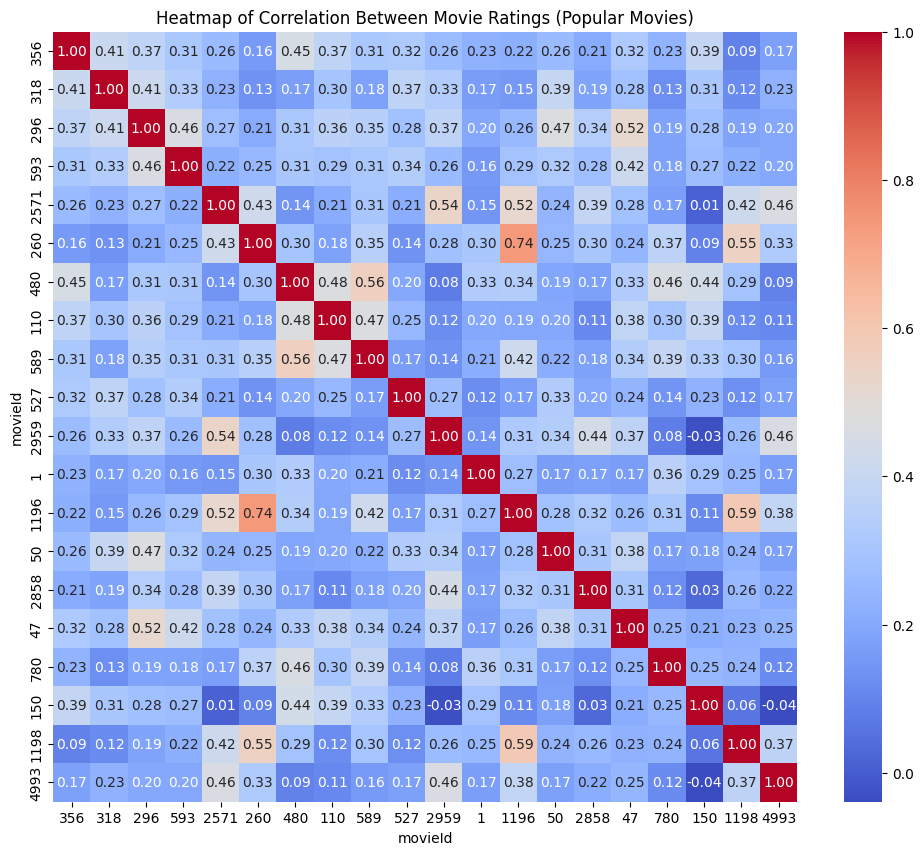

In [97]:
popular_movies = movie_popularity.nlargest(20, 'rating_count')['movieId']
ratings_subset = ratings_matrix[popular_movies]

# Calculate the correlation matrix
correlation_matrix = ratings_subset.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Between Movie Ratings (Popular Movies)')
plt.show()

## Modeling

### Collaborative Filtering - Matrix Factorization (SVD)

In [119]:
# Create a Surprise Dataset
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(filtered_ratings[['userId', 'movieId', 'rating']], reader)

# Train the SVD model
trainset = data.build_full_trainset()
svd_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
svd_model.fit(trainset)

# Function to get top N recommendations for a user
def get_top_n_recommendations(user_id, n=5):
    # Get all movies the user has not rated
    user_rated_movies = set(filtered_ratings[filtered_ratings['userId'] == user_id]['movieId'])
    all_movies = set(filtered_ratings['movieId'].unique())
    unrated_movies = list(all_movies - user_rated_movies)

    # Predict ratings for unrated movies
    predictions = []
    for movie_id in unrated_movies:
        prediction = svd_model.predict(user_id, movie_id)
        predictions.append((movie_id, prediction.est))

    # Sort predictions by estimated rating and get top N
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n = predictions[:n]

    # Return movie titles instead of IDs
    top_n_movies = []
    for movie_id, rating in top_n:
      movie_title = movies[movies['movieId']==movie_id]['title'].values[0]
      top_n_movies.append((movie_title, rating))

    return top_n_movies

user_id = 1
recommendations = get_top_n_recommendations(user_id)
print(f"Top 5 movie recommendations for user {user_id}:")
for movie, rating in recommendations:
    print(f"- {movie} (Predicted rating: {rating:.2f})")


Top 5 movie recommendations for user 1:
- City of Lost Children, The (Cité des enfants perdus, La) (1995) (Predicted rating: 5.00)
- Hoop Dreams (1994) (Predicted rating: 5.00)
- Shawshank Redemption, The (1994) (Predicted rating: 5.00)
- Wallace & Gromit: A Close Shave (1995) (Predicted rating: 5.00)
- Trainspotting (1996) (Predicted rating: 5.00)


### Content-Based Filtering (Using Movie Metadata)

In [106]:
# Create a TF-IDF matrix from the movie genres
tfidf = CountVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Compute the cosine similarity between movies based on the TF-IDF matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations based on genre similarity
def content_based_recommendations(movie_title, cosine_sim=cosine_sim):
    # Get the index of the movie
    idx = movies.index[movies['title'] == movie_title].tolist()[0]

    # Get the pairwise similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top 5 most similar movies
    sim_scores = sim_scores[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 5 recommended movies
    return movies['title'].iloc[movie_indices]

# using Toy Story (1995) as an example but you can replace it with the movie title you want
recommendations = content_based_recommendations('Toy Story (1995)')
recommendations


,title
1706,Antz (1998)
2355,Toy Story 2 (1999)
2809,"Adventures of Rocky and Bullwinkle, The (2000)"
3000,"Emperor's New Groove, The (2000)"
3568,"Monsters, Inc. (2001)"


This code is implementing a content-based movie recommendation system using genre similarity so as to recommend movies that are similar in genre to a given movie, hence returning a list of 5 movies that have the most similar genres to the movie.we decided to use "Toy Story (1995)" as an example.



###Hybrid models

In [120]:
def hybrid_recommendations(user_id, n_recommendations=5):
    """
    Generate hybrid recommendations by combining collaborative filtering and content-based filtering.

    Args:
        user_id: The ID of the user for whom to generate recommendations.
        n_recommendations: The number of recommendations to generate.

    Returns:
        A list of movie titles representing the recommendations.
    """
    # Get collaborative filtering recommendations
    collab_recs = collaborative_recommendations(user_id, n_recommendations * 2)

    # Get content-based recommendations for each of the collab movies
    content_based_candidates = []
    for movie_id, _ in collab_recs:
        content_based_candidates.extend(content_based_recommendations(movie_id))

    # Combine and rank
    hybrid_scores = {}
    for movie_id, score in collab_recs:
        hybrid_scores[movie_id] = score

    for movie_id in content_based_candidates:
        if movie_id not in hybrid_scores:
            # Estimate rating using SVD for unseen movies in content recommendations
            prediction = svd.predict(user_id, movie_id)
            hybrid_scores[movie_id] = prediction.est

    sorted_hybrid = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)

    # Get movie titles instead of IDs:
    recommended_movie_titles = []
    for movie_id, _ in sorted_hybrid[:n_recommendations]:
        title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
        recommended_movie_titles.append(title)

    return recommended_movie_titles  # Return movie titles

# using user_ID = 1 as an example but you replace with the user ID you want recommendations for
user_id = 1
recommended_movies = hybrid_recommendations(user_id)
recommended_movies

['Shawshank Redemption, The (1994)',
 'Lion King, The (1994)',
 'In the Name of the Father (1993)',
 'Blade Runner (1982)',
 'Wallace & Gromit: The Best of Aardman Animation (1996)']

# MODEL EVALUATION

### Model evaluation using RMSE

In [121]:
from sklearn.metrics import mean_squared_error
import math

def rmse_evaluation(predictions):
    """
    Calculates the Root Mean Squared Error (RMSE) for a list of predictions.

    Args:
        predictions: A list of Prediction objects from Surprise library.

    Returns:
        The RMSE value.
    """
    true_ratings = [pred.r_ui for pred in predictions]
    estimated_ratings = [pred.est for pred in predictions]
    rmse = math.sqrt(mean_squared_error(true_ratings, estimated_ratings))
    return rmse
from surprise.model_selection import train_test_split

# Assuming 'reader' is the reader object defined previously
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(filtered_ratings[['userId', 'movieId', 'rating']], reader=reader)

trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Train an SVD model
algo = SVD()
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Calculate and print the RMSE
rmse = rmse_evaluation(predictions)
print(f"RMSE: {rmse}")


RMSE: 0.8577033705647412


## Model evaluation using MAE

In [123]:
from sklearn.metrics import mean_absolute_error

def mae_evaluation(predictions):
    """
    Calculates the Mean Absolute Error (MAE) for a list of predictions.

    Args:
        predictions: A list of Prediction objects from Surprise library.

    Returns:
        The MAE value.
    """
    true_ratings = [pred.r_ui for pred in predictions]
    estimated_ratings = [pred.est for pred in predictions]
    mae = mean_absolute_error(true_ratings, estimated_ratings)
    return mae

# Assuming 'predictions' is the list of predictions from the SVD model
mae = mae_evaluation(predictions)
print(f"MAE: {mae}")


MAE: 0.6586869449672015


# Conclusions and recomendations